In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H-2024-Task5-Training.tsv', sep='\t')
df_dev = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H-2024-Task5-Validation.tsv', sep='\t')

In [3]:
!pip install transformers seqeval torch tqdm accelerate sentencepiece datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f143083a4e391b48e24bfdb04b38ba6d08d91c48d2541c026dd97b37ad3518b7
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [4]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=24,
    warmup_steps=0,
    weight_decay=0.05,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="no",
    save_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()
trainer.save_model("./miniLM_model")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.640800
200,0.589000
300,0.562500
400,0.557200
500,0.524700
600,0.489500


In [5]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/miniLM_model')
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])
df_predictions

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

,predicted_label,prediction_0_weight,prediction_1_weight
0,0,0.837015,0.162985
1,1,0.471032,0.528968
2,0,0.842213,0.157787
3,1,0.275157,0.724843
4,0,0.798708,0.201292
...,...,...,...
384,0,0.616699,0.383301
385,0,0.838486,0.161514
386,0,0.791712,0.208288
387,0,0.802661,0.197339


In [6]:
df_merged = pd.concat([df_dev, df_predictions], axis=1)
df_merged

,tweet_id,text,label,predicted_label,prediction_0_weight,prediction_1_weight
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0,0,0.837015,0.162985
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0,1,0.471032,0.528968
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0,0,0.842213,0.157787
3,1107948318150152192,"@amyschumer watching #growing, my 2yo son has ...",1,1,0.275157,0.724843
4,1438320313511473154,@robbystarbuck @AmericanAir would rather a mot...,0,0,0.798708,0.201292
...,...,...,...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0,0,0.616699,0.383301
385,1084086161667252225,@attachedmrsL the first reply on the tweet tho...,0,0,0.838486,0.161514
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0,0,0.791712,0.208288
387,1458807608052174856,@itsadollthxng Lmfao girl !!! I’m upset fr cau...,1,0,0.802661,0.197339


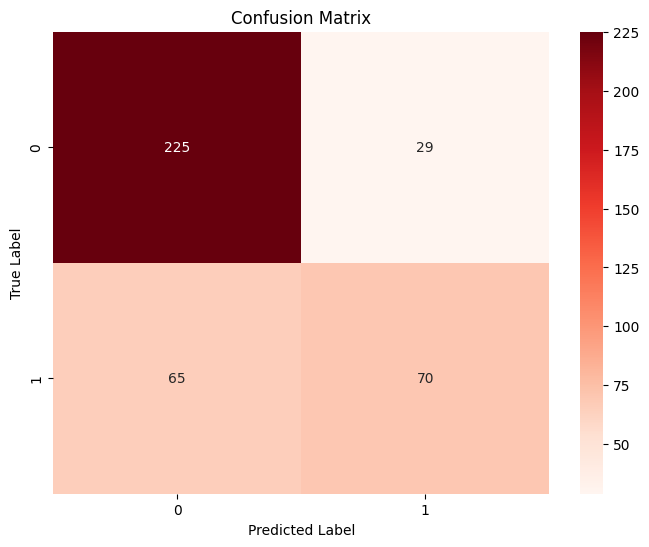

Accuracy: 0.7583547557840618
F1 Score (Class 1): 0.5982905982905983
Recall (Macro): 0.7021726450860308
Precision (Macro): 0.7414663880181122


In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged['label']
predicted_labels = df_merged['predicted_label']
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")

In [12]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=24,
    warmup_steps=0,
    weight_decay=0.05,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="no",
    save_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()
trainer.save_model("./miniLM_model_2")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.641600
200,0.595900
300,0.526600
400,0.570200
500,0.517000
600,0.486900
700,0.450700
800,0.445800
900,0.449900
1000,0.450700


Checkpoint destination directory ./results/checkpoint-617 already exists and is non-empty.Saving will proceed but saved results may be invalid.


In [13]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/miniLM_model_2')
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_2 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])
df_predictions_2

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

,predicted_label,prediction_0_weight,prediction_1_weight
0,0,0.905374,0.094626
1,1,0.298605,0.701395
2,0,0.908098,0.091902
3,1,0.157052,0.842948
4,0,0.894911,0.105089
...,...,...,...
384,1,0.214656,0.785344
385,0,0.900637,0.099363
386,0,0.881532,0.118468
387,0,0.901424,0.098576


In [14]:
df_merged_2 = pd.concat([df_dev, df_predictions_2], axis=1)
df_merged_2

,tweet_id,text,label,predicted_label,prediction_0_weight,prediction_1_weight
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0,0,0.905374,0.094626
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0,1,0.298605,0.701395
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0,0,0.908098,0.091902
3,1107948318150152192,"@amyschumer watching #growing, my 2yo son has ...",1,1,0.157052,0.842948
4,1438320313511473154,@robbystarbuck @AmericanAir would rather a mot...,0,0,0.894911,0.105089
...,...,...,...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0,1,0.214656,0.785344
385,1084086161667252225,@attachedmrsL the first reply on the tweet tho...,0,0,0.900637,0.099363
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0,0,0.881532,0.118468
387,1458807608052174856,@itsadollthxng Lmfao girl !!! I’m upset fr cau...,1,0,0.901424,0.098576


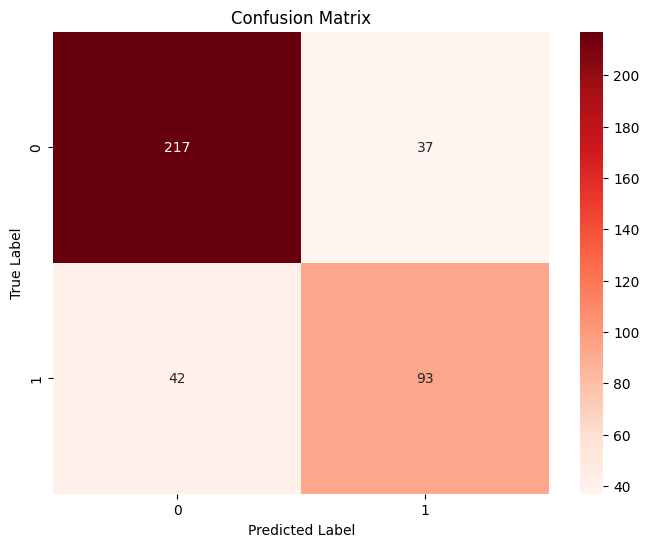

Accuracy: 0.7969151670951157
F1 Score (Class 1): 0.7018867924528303
Recall (Macro): 0.7716097987751531
Precision (Macro): 0.7766112266112266


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_2['label']
predicted_labels = df_merged_2['predicted_label']
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")

In [16]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=24,
    warmup_steps=0,
    weight_decay=0.05,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="no",
    save_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()
trainer.save_model("./miniLM_model_3")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.642700
200,0.608700
300,0.584400
400,0.556800
500,0.538300
600,0.493800
700,0.472200
800,0.460800
900,0.457600
1000,0.452400


Checkpoint destination directory ./results/checkpoint-617 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1234 already exists and is non-empty.Saving will proceed but saved results may be invalid.


In [17]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/miniLM_model_3')
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_3 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])
df_predictions_3

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

,predicted_label,prediction_0_weight,prediction_1_weight
0,0,0.936812,0.063188
1,0,0.866037,0.133963
2,0,0.936526,0.063474
3,1,0.101710,0.898290
4,0,0.926913,0.073087
...,...,...,...
384,1,0.429605,0.570395
385,0,0.912398,0.087602
386,0,0.907039,0.092961
387,0,0.937054,0.062947


In [18]:
df_merged_3 = pd.concat([df_dev, df_predictions_3], axis=1)
df_merged_3

,tweet_id,text,label,predicted_label,prediction_0_weight,prediction_1_weight
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0,0,0.936812,0.063188
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0,0,0.866037,0.133963
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0,0,0.936526,0.063474
3,1107948318150152192,"@amyschumer watching #growing, my 2yo son has ...",1,1,0.101710,0.898290
4,1438320313511473154,@robbystarbuck @AmericanAir would rather a mot...,0,0,0.926913,0.073087
...,...,...,...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0,1,0.429605,0.570395
385,1084086161667252225,@attachedmrsL the first reply on the tweet tho...,0,0,0.912398,0.087602
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0,0,0.907039,0.092961
387,1458807608052174856,@itsadollthxng Lmfao girl !!! I’m upset fr cau...,1,0,0.937054,0.062947


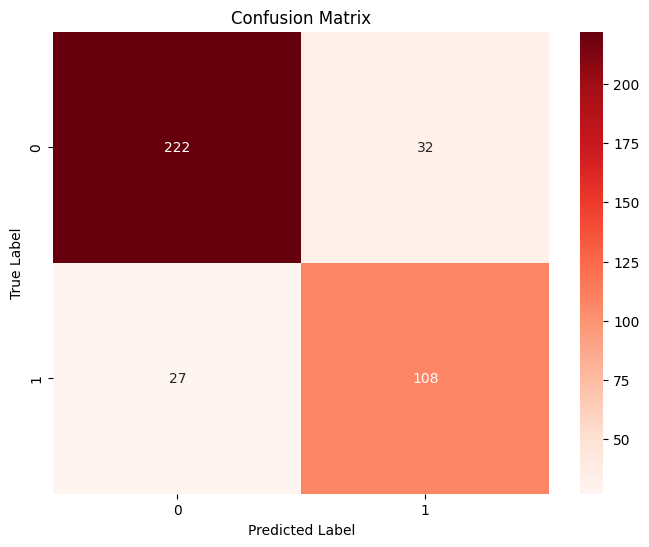

Accuracy: 0.8483290488431876
F1 Score (Class 1): 0.7854545454545454
Recall (Macro): 0.837007874015748
Precision (Macro): 0.8314974182444062


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_3['label']
predicted_labels = df_merged_3['predicted_label']
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")

In [20]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    learning_rate=2e-5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=24,
    warmup_steps=0,
    weight_decay=0.05,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="no",
    save_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()
trainer.save_model("./miniLM_model_4")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.641800
200,0.588600
300,0.547300
400,0.548200
500,0.519600
600,0.471700
700,0.449300
800,0.432700
900,0.445800
1000,0.445100


Checkpoint destination directory ./results/checkpoint-617 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1234 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1851 already exists and is non-empty.Saving will proceed but saved results may be invalid.


In [21]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/miniLM_model_4')
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_4 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])
df_predictions_4

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

,predicted_label,prediction_0_weight,prediction_1_weight
0,0,0.955403,0.044597
1,0,0.671270,0.328730
2,0,0.955621,0.044379
3,1,0.056229,0.943771
4,0,0.950170,0.049830
...,...,...,...
384,1,0.079483,0.920517
385,0,0.943733,0.056267
386,0,0.947333,0.052667
387,0,0.953610,0.046390


In [22]:
df_merged_4 = pd.concat([df_dev, df_predictions_4], axis=1)
df_merged_4

,tweet_id,text,label,predicted_label,prediction_0_weight,prediction_1_weight
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0,0,0.955403,0.044597
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0,0,0.671270,0.328730
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0,0,0.955621,0.044379
3,1107948318150152192,"@amyschumer watching #growing, my 2yo son has ...",1,1,0.056229,0.943771
4,1438320313511473154,@robbystarbuck @AmericanAir would rather a mot...,0,0,0.950170,0.049830
...,...,...,...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0,1,0.079483,0.920517
385,1084086161667252225,@attachedmrsL the first reply on the tweet tho...,0,0,0.943733,0.056267
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0,0,0.947333,0.052667
387,1458807608052174856,@itsadollthxng Lmfao girl !!! I’m upset fr cau...,1,0,0.953610,0.046390


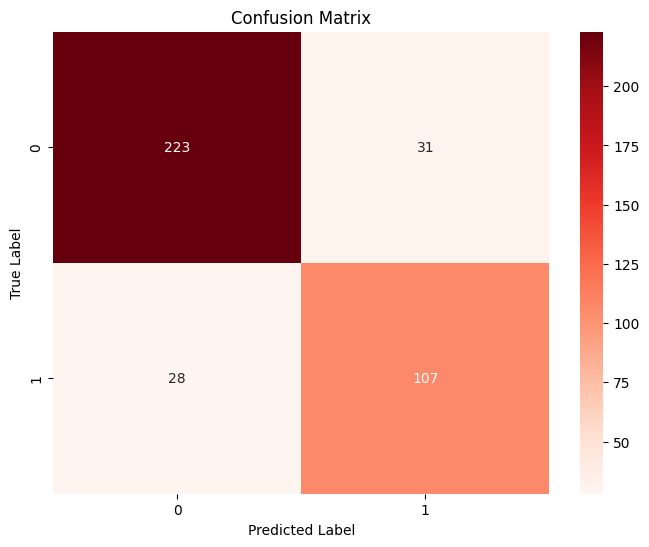

Accuracy: 0.8483290488431876
F1 Score (Class 1): 0.7838827838827839
Recall (Macro): 0.8352726742490522
Precision (Macro): 0.831904266990011


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_4['label']
predicted_labels = df_merged_4['predicted_label']
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")

In [24]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=24,
    warmup_steps=0,
    weight_decay=0.05,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="no",
    save_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()
trainer.save_model("./miniLM_model_5")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.642900
200,0.604700
300,0.554900
400,0.555300
500,0.533900
600,0.495100
700,0.470100
800,0.450500
900,0.462300
1000,0.455400


Checkpoint destination directory ./results/checkpoint-617 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1234 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1851 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2468 already exists and is non-empty.Saving will proceed but saved results may be invalid.


In [25]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/miniLM_model_5')
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_5 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])
df_predictions_5

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

,predicted_label,prediction_0_weight,prediction_1_weight
0,0,0.966542,0.033458
1,0,0.936816,0.063184
2,0,0.964973,0.035027
3,1,0.041196,0.958804
4,0,0.966534,0.033466
...,...,...,...
384,1,0.176760,0.823240
385,0,0.964858,0.035142
386,0,0.962836,0.037164
387,0,0.964961,0.035039


In [26]:
df_merged_5 = pd.concat([df_dev, df_predictions_5], axis=1)
df_merged_5

,tweet_id,text,label,predicted_label,prediction_0_weight,prediction_1_weight
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0,0,0.966542,0.033458
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0,0,0.936816,0.063184
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0,0,0.964973,0.035027
3,1107948318150152192,"@amyschumer watching #growing, my 2yo son has ...",1,1,0.041196,0.958804
4,1438320313511473154,@robbystarbuck @AmericanAir would rather a mot...,0,0,0.966534,0.033466
...,...,...,...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0,1,0.176760,0.823240
385,1084086161667252225,@attachedmrsL the first reply on the tweet tho...,0,0,0.964858,0.035142
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0,0,0.962836,0.037164
387,1458807608052174856,@itsadollthxng Lmfao girl !!! I’m upset fr cau...,1,0,0.964961,0.035039


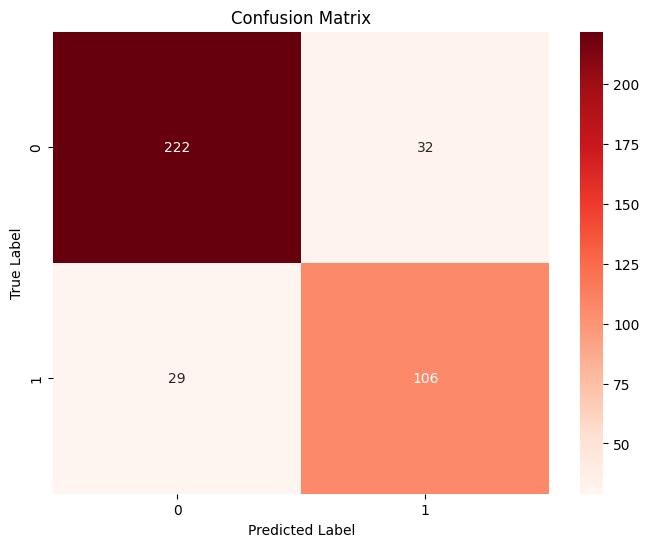

Accuracy: 0.8431876606683805
F1 Score (Class 1): 0.7765567765567766
Recall (Macro): 0.8296004666083406
Precision (Macro): 0.8262890467117039


In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_5['label']
predicted_labels = df_merged_5['predicted_label']
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")

In [28]:
df_merged.to_csv('MiniLM_task5_predictions_epoch1.csv', index=False)
df_merged_2.to_csv('MiniLM_task5_predictions_epoch2.csv', index=False)
df_merged_3.to_csv('MiniLM_task5_predictions_epoch3.csv', index=False)
df_merged_4.to_csv('MiniLM_task5_predictions_epoch4.csv', index=False)
df_merged_5.to_csv('MiniLM_task5_predictions_epoch5.csv', index=False)